In [ ]:
pip install tensorflow

In [ ]:
pip install opencv-python

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import os
import tensorflow as tf
from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import  GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import  Adam
import cv2
from tensorflow.keras.applications.resnet50 import ResNet50

In [3]:
#change to your own working directory
path = 'C:/path/to/your/project/directory'

In [ ]:
train_path = os.path.join(path, 'Intel_images', 'train')
test_path = os.path.join(path, 'Intel_images', 'test')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
for im in os.listdir(train_path):
    num = 0
    img_class = (os.path.join(train_path, im))
    img = os.listdir(img_class)
    img_path = os.path.join(train_path, img_class, img[0])
    image = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))   
    plt.axis('off')
    plt.title(im)
    plt.show()

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    color_mode = 'rgb',
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    color_mode = 'rgb',
    class_mode='categorical')

In [ ]:
base_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (150, 150, 3))
resnet = base_model.output
resnet = GlobalAveragePooling2D()(resnet)
resnet = Dropout(0.25)(resnet)
predictions = Dense(6, activation= 'softmax')(resnet)
Resnet50 = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
adam = Adam(learning_rate = 0.0001)
Resnet50.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
History = Resnet50.fit(train_generator, 
                                 batch_size = 128,
                                 epochs = 1,
                                 validation_data = (test_generator))

In [ ]:
epochs= []
for i in range(5):
    epochs.append(i)
    
plt.figure(figsize = (15, 10))    
plt.plot(epochs,History.history['accuracy'], label="Train")
plt.plot(epochs,History.history['val_accuracy'], label="Test")
plt.title("Train-Test Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (15, 10))   
plt.plot(epochs,History.history['loss'], label="Train")
plt.plot(epochs,History.history['val_loss'], label="Test")
plt.title("Train-Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#show images and predicted labels
pred_path = os.path.join(path, 'Intel_images', 'pred')
pred_list = os.listdir(pred_path)

for i in range(210, 220):
    img_path = os.path.join(pred_path, pred_list[i])
    img = cv2.imread(img_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    plt.show()
    img_res = np.expand_dims(img/255, 0)
    if (np.argmax(Resnet50.predict(img_res))) == 0:
        print('Predict Building')
    elif (np.argmax(Resnet50.predict(img_res))) == 1:
        print('Predict Forest')
    elif (np.argmax(Resnet50.predict(img_res))) == 2:
        print('Predict Glacier')
    elif (np.argmax(Resnet50.predict(img_res))) == 3:
        print('Predict Mountain')
    elif (np.argmax(Resnet50.predict(img_res))) == 4:
        print('Predict Sea')
    else:
        print('Predict Street')

In [ ]:
# Save model:
model_path = os.path.join(path, 'model', 'Resnet50.pt')
torch.save(Resnet50, model_path)

## Model Explanation with LIME

In [1]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [9]:
#change to your own working directory
path = 'C:/path/to/your/project/directory'

In [2]:
explainer = lime_image.LimeImageExplainer()

In [31]:
#Load saved model
model_path = os.path.join(path, 'model', 'Resnet50.pt')
Resnet50 = torch.load(model_path)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2022-12-11 19:03:14        85876
metadata.json                                  2022-12-11 19:03:14           64
variables.h5                                   2022-12-11 19:03:14    283400208
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\activation
......vars
...layers\activation_1
......vars
...layers\activation_10
......vars
...layers\activation_11
......vars
...layers\activation_12
......vars
...layers\activation_13
......vars
...layers\activation_14
......vars
...layers\activation_15
......vars
...layers\activation_16
......vars
...layers\activation_17
......vars
...layers\activation_18
......vars
...layers\activation_19
......vars
...layers\activation_2
......vars
...layers\activation_20
......vars
...layers\activation_21
......vars
...layers\activation_22
......vars
...layers\activation_23
......

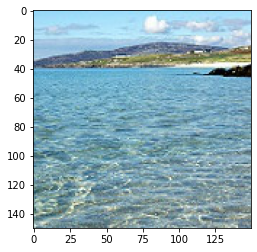

In [26]:
#show one image from prediction dataset
pred_path = os.path.join(path, 'Intel_images', 'pred')
pred_list = os.listdir(pred_path)
pred_path = os.path.join(path, 'Intel_images', 'pred', pred_list[100])
img = cv2.imread(pred_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()
img_res = img/255

In [27]:
exp = explainer.explain_instance(img_res, 
                                 Resnet50.predict, 
                                 top_labels=5, 
                                 hide_color=0, 
                                 num_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 237ms/step


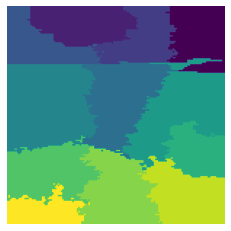

In [28]:
# visualize the various explanation segments created by the LIME algorithm
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

In [29]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()

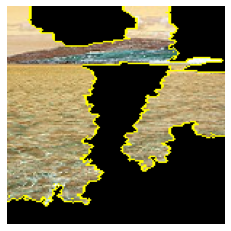

In [30]:
#identify the region of interest of the image used by the model to make its prediction
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

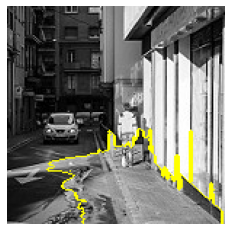

In [23]:
#highlight the contour of the superpixel and include the background as well
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

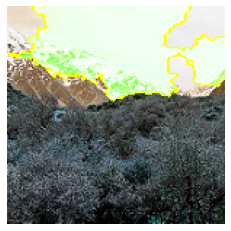

In [14]:
#highlight the positive super-pixels and negative superpixels
generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)

In [24]:
def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    plt.show()

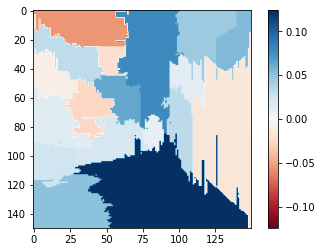

In [25]:
#get heat-map to show how important each super-pixel is
explanation_heatmap(exp, exp.top_labels[0])